# Homework 8

## 1. Conceptual issues for LTCM

### 1.1 Describe LTCM's investment strategy with regard to the following aspects:
- Securities traded
- Trading Frequency
- Skewness (Do they seek many small wins or a few big hits?)
- Forecasting (What is behind their selection of trades?)**

LTCM primarily engaged in convergence and relative value strategies. They traded various instruments from (Fixed Income, FX, Equities, Derivatives), but their largest trades were in the fixed income space.

They traded fairly mid-to-long term, but were not against going short term. True to their name, they believed that their positions could eventually converge to fair value and were willing to hold on to them but at the same time could easily unwind positions if the value was realised quickly. 

Given that their model works on exploiting small mispricings or arbitrage opportunities (which tend not to be large gaps), we would say they seek many small wins which they "lever up". 

LTCM's trades involved complex prop trading strats driven by sophisticated or complicated models. They had several employees who were experts in quantitative analysis and modeling, and sought to create an edge via their talent (i.e. belief that their advanced models could predict and exploit small inefficiencies in the market better than the competition)

### 1.2 What are LTCM’s biggest advantages over its competitors?

LTCM's biggest advantage was its brand name partnership and management team. Many of them had exceptional resumes and were very high-profile in the finance sector. This was a major draw for capital injection into LTCM and also gave them an intellectual edge (both in terms of the work the team could do and the people the team could subsequently attract). 

This created a flywheel of opportunities in terms of eventual models' sophistication, access to funding and liquidity, ability to leverage (relative to other firms), and so on. 

### 1.3 The case discusses four types of funding risk facing LTCM:
- collateral haircuts
- repo maturity
- equity redemption
- loan access

The case discusses specific ways in which LTCM manages each of these risks. Briefly discuss them.

1. Collateral Haircuts: case page 15 last paragraph on modeling financing haircuts
2. Repo Maturity: case page 14 on average maturity monitoring
3. Equity Redemption: case page 14 on lock up
4. Loan Access: case page 14 on syndicate of revolving credit

### 1.4 LTCM is largely in the business of selling liquidity and volatility. Describe how LTCM accounts for liquidity risk in their quantitative measurements.

The firm mostly viewed liquidity risk as an opportunity as they deem it to be short lived relative to their investment horizon.

### 1.5 Is leverage risk currently a concern for LTCM?

As of the time of the article, yes it is and should be as LTCM heavily uses leverage to set up its trades. 

### 1.6 Many strategies of LTCM rely on converging spreads. LTCM feels that these are almost win/win situations because of the fact that if the spread converges, they make money. If it diverges, the trade becomes even more attractive, as convergence is still expected at a future date. What is the risk in these convergence trades?

## 2. LTCM Risk Decomposition
- On Canvas, find the data file, “ltcm exhibits data.xlsx”. Get the gross and net (total) returns of LTCM from “Exhibit 2”.
- Get the returns on SPY as well as the risk-free rate from the file, “gmo analysis data”.

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import sys
import os
import warnings
warnings.filterwarnings('ignore')

#helper functions
def freq_multiplier(input_freq, output_freq):
    """
    multiplies the input frequency to the output frequency
    """
    multiplier = 1

    if input_freq == 'm':
        multiplier *= 12
    elif input_freq == 'w':
        multiplier *= 52
    elif input_freq == 'd':
        multiplier *= 252
    elif input_freq == 'a':
        multiplier *= 1
    else:
        print('invalid input frequency')
        return
    
    if output_freq == 'm':
        multiplier /= 12
    elif output_freq == 'w':
        multiplier /= 52
    elif output_freq == 'd':
        multiplier /= 252
    elif output_freq == 'a':
        pass

    return multiplier

def calc_stats(df, input_freq = 'm', output_freq = 'a', ci_level = 0.05):
    """
    Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    multiplier = freq_multiplier(input_freq, output_freq)

    # calculate mean, vol, sharpe, VaR(5%), CVaR(5%) for each item in df
    summary_stats = df.mean().to_frame('Mean').apply(lambda x: x * multiplier)
    summary_stats['Volatility'] = df.std() * np.sqrt(multiplier)
    summary_stats['Sharpe Ratio'] = summary_stats['Mean'] / summary_stats['Volatility']
    summary_stats['Skewness'] = df.skew()
    summary_stats['Excess Kurtosis'] = df.kurtosis()
    summary_stats[f'VaR ({ci_level*100}%)'] = df.quantile(ci_level, axis = 0)
    summary_stats[f'CVaR ({ci_level*100}%)'] = df[df <= df.quantile(ci_level, axis = 0)].mean()

    summary_stats['Min Return'] = df.min()
    summary_stats['Max Return'] = df.max()
    cum_returns = (1 + df).cumprod()
    previous_peaks = cum_returns.cummax()
    drawdowns = (cum_returns - previous_peaks) / previous_peaks
    summary_stats['Max Drawdown'] = drawdowns.min()
    # find the last date of the min drawdown
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()

    # calculate recovery time
    recovery_date = []
    for col in cum_returns.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_cum = pd.DataFrame([cum_returns[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_cum[recovery_cum[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date   

    return summary_stats

def pre_post_calc_stats_comp(df, pre, post, input_freq = 'm', output_freq = 'a', ci_level = 0.05):
    """
    Returns the performance stats for a given set of excess returns but comparing 2 time periods.
    Uses the cal_stats function above:
        Inputs: 
            return_data - DataFrame with Date index and Returns for different assets/strategies, as well as the pre and post periods in string format (e.g. '2014')
        Output:
            summary_stats - DataFrame with mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    df.index = df.index.normalize()
    df_pre = df.loc[:pre]
    df_post = df.loc[post:]

    stats_pre = calc_stats(df_pre, input_freq, output_freq, ci_level)
    stats_post = calc_stats(df_post, input_freq, output_freq, ci_level)

    # combined summary stats for all subsamples in one dataframe with period as column
    stats_pre['Period'] = f'from {df_pre.index[0].strftime("%Y")} to {pre}'
    stats_post['Period'] = f'{post} - present'
    summary_stats = pd.concat([stats_pre, stats_post]).reset_index().rename(columns = {'index': 'Factor'}).set_index(['Period', 'Factor'])
    
    return summary_stats

def plot_time_series(df, pre = None, post = None):
    """
    Plots the factors over time. Also, includes a line demarcating the pre and post periods if pre is available.
    Will also throw the cumulative returns plot for pre and post if pre and post available.
    """
    fig, ax = plt.subplots(figsize = (10, 5))
    cum_returns = (1 + df).cumprod() - 1
    cum_returns.plot(ax = ax)
    ax.set_title('Cumulative Returns of Factors')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Returns')
    
    if pre is not None and post is not None:
        ax.axvline(x=pre, color='k', linestyle='--')
        ax.legend(['Cumulative Returns', 'Pre', 'Post'])
        
        # Plot cumulative returns for pre period
        fig_pre, ax_pre = plt.subplots(figsize=(10, 5))
        cum_returns_pre = (1 + df.loc[:pre]).cumprod() - 1
        cum_returns_pre.plot(ax=ax_pre)
        ax_pre.set_title('Cumulative Returns of Factors - Pre')
        ax_pre.set_xlabel('Date')
        ax_pre.set_ylabel('Cumulative Returns')
        
        # Reset the cumulative returns for the post period
        df_post = df.loc[post:]
        df_post = df_post - df_post.iloc[0] + 1  # Reset to start from 1
        cum_returns_post = df_post.cumprod() - 1
        
        fig_post, ax_post = plt.subplots(figsize=(10, 5))
        cum_returns_post.plot(ax=ax_post)
        ax_post.set_title('Cumulative Returns of Factors - Post')
        ax_post.set_xlabel('Date')
        ax_post.set_ylabel('Cumulative Returns')
        
        return fig, ax, fig_pre, ax_pre, fig_post, ax_post
    else:
        return fig, ax

def plot_corr_matrix(df):
    """
    plot correlation matrices for a set of time series data.
    """
    fig, ax = plt.subplots(figsize = (10, 5))
    sns.heatmap(df.corr(), annot = True, cmap = 'Blues', ax = ax)
    ax.set_title('Correlation Matrix')
    return fig, ax

def tangency_weights(df, input_freq = 'm', output_freq = 'a'):
    """
    Returns the weights of the tangency portfolio for given set of returns and covariance matrix.
    Also returns the annualised returns, vol and sharpe ratio of each asset in the portfolio
    """
    multipler = freq_multiplier(input_freq, output_freq)

    # calculate the mean returns and covariance matrix
    mean_returns = df.mean() * multipler
    cov_matrix = df.cov() * multipler
    cov_inv = np.linalg.inv(cov_matrix)

    # calculate the tangency portfolio weights
    tangency_weights = cov_inv.dot(mean_returns)
    tangency_weights /= tangency_weights.sum()

    #create a dataframe with weights and asset names
    tangency_weights = pd.DataFrame(tangency_weights, index = df.columns, columns = ['Weights'])

    return tangency_weights

def regression_based_performance(factor, fund_ret, rf=0, input_freq='m', output_freq='a', constant=True, model_type='linear', k1=None, k2=None):
    """
    Returns the regression based performance of a factor against a fund.
    Allows for linear, quadratic, and piecewise linear regression models.
    """
    # Convert the input frequency to output frequency for the factor and fund returns
    multiplier = freq_multiplier(input_freq, output_freq)
    
    # Create the design matrix based on the model type
    if model_type == 'linear':
        X = sm.add_constant(factor) if constant else factor
    elif model_type == 'quadratic':
        X = sm.add_constant(np.column_stack((factor, factor**2))) if constant else np.column_stack((factor, factor**2))
    elif model_type == 'piecewise':
        if k1 is None or k2 is None:
            raise ValueError("k1 and k2 must be provided for piecewise linear regression")
        # Calculate the piecewise components
        upside = np.maximum(factor - k1, 0)
        downside = np.maximum(k2 - factor, 0)
        X = sm.add_constant(np.column_stack((factor, upside, downside))) if constant else np.column_stack((factor, upside, downside))
    else:
        raise ValueError("model_type must be 'linear', 'quadratic', or 'piecewise'")
    
    # Fit the model
    model = sm.OLS(fund_ret, X, missing='drop').fit()
    
    # Extract the model parameters
    if constant:
        alpha = round(model.params['const'] * multiplier, 6)
        beta = model.params[1]
    else:
        alpha = 0
        beta = model.params[0]

    # Additional parameters for quadratic and piecewise models
    beta_squared = model.params[2] if model_type == 'quadratic' else None
    beta_u = model.params[2] if model_type == 'piecewise' else None
    beta_d = model.params[3] if model_type == 'piecewise' else None

    # Calculate the annualized metrics
    r_squared = model.rsquared
    treynor_ratio = (fund_ret.mean() - rf) * multiplier / beta
    tracking_error = np.sqrt(model.resid.var() * multiplier)
    information_ratio = (alpha / multiplier) / tracking_error

    # Create the results DataFrame
    data = {
        'alpha': alpha,
        'beta': beta,
        'r_squared': r_squared,
        'tracking_error': tracking_error,
        'treynor_ratio': treynor_ratio,
        'information_ratio': information_ratio
    }
    if model_type == 'quadratic':
        data['beta_squared'] = beta_squared
    if model_type == 'piecewise':
        data['beta_u'] = beta_u
        data['beta_d'] = beta_d

    regression_results = pd.DataFrame(data, index=['Value']).T

    return regression_results, model

In [74]:
FILEIN1 = '/Users/kaiwentay/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/finm-portfolio-2022/data/gmo_analysis_data.xlsx'
FILEIN2 = '/Users/kaiwentay/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/finm-portfolio-2022/data/ltcm_exhibits_data.xlsx'
FILEIN3 = '/Users/kaiwentay/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/finm-portfolio-2022/data/fx_carry_data.xlsx'

# reference github repo finm-portfolio-2022
ltcm_exhibit_2 = pd.read_excel(FILEIN2, sheet_name=1, skiprows=(0,1), usecols='A:E').dropna().rename(columns={'Unnamed: 0':'Date','Gross Monthly Performancea':'Gross','Net Monthly Performanceb':'Net'}).set_index('Date')
ltcm_exhibit_2.index = ltcm_exhibit_2.index.to_period('M').to_timestamp('M')
ltcm_exhibit_4 = pd.read_excel(FILEIN2, sheet_name=2, skiprows=(0,1), usecols='A:E').dropna().rename(columns={'Month':'Date'}).set_index('Date')
ltcm_exhibit_4.index = ltcm_exhibit_4.index.to_period('M').to_timestamp('M')

gmo_returns = pd.read_excel(FILEIN1, sheet_name = 'returns (total)', index_col = 0, parse_dates = True)
gmo_returns = gmo_returns.iloc[:, 0].to_frame('SPY')
gmo_rfr = pd.read_excel(FILEIN1, sheet_name = 'risk-free rate', index_col = 0, parse_dates = True)

# fx data
fxspot = pd.read_excel(FILEIN3,sheet_name=2,index_col='DATE')
rf = pd.read_excel(FILEIN3,sheet_name=1,index_col='DATE')

In [30]:
returns_data = ltcm_exhibit_2.copy()
returns_data['SPY'] = gmo_returns['SPY']
returns_data = returns_data.subtract(gmo_rfr['US3M'].loc['1994-03':'1998-07'], axis = 0)


### 2.1 Summary stats:
(a) For both the gross and net series of LTCM excess returns, report the mean, volatility, and Sharpe ratios. (Annualize them.)

(b) Report the skewness, kurtosis, and (historic) VaR(.05)

(c) Comment on how these stats compare to SPY and other assets we have seen. How much do they differ between gross and net?

In [37]:
returns_stats = calc_stats(returns_data[['Gross', 'Net', 'SPY']], input_freq = 'm', output_freq = 'a', ci_level = 0.05)
returns_stats.iloc[:, :7]

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (5.0%),CVaR (5.0%)
Gross,0.242077,0.136232,1.776946,-0.287725,1.586625,-0.030445,-0.072997
Net,0.155360,0.111765,1.390059,-0.810239,2.926921,-0.026415,-0.068664
SPY,0.173823,0.112294,1.547923,-0.433516,-0.362022,-0.046360,-0.051379


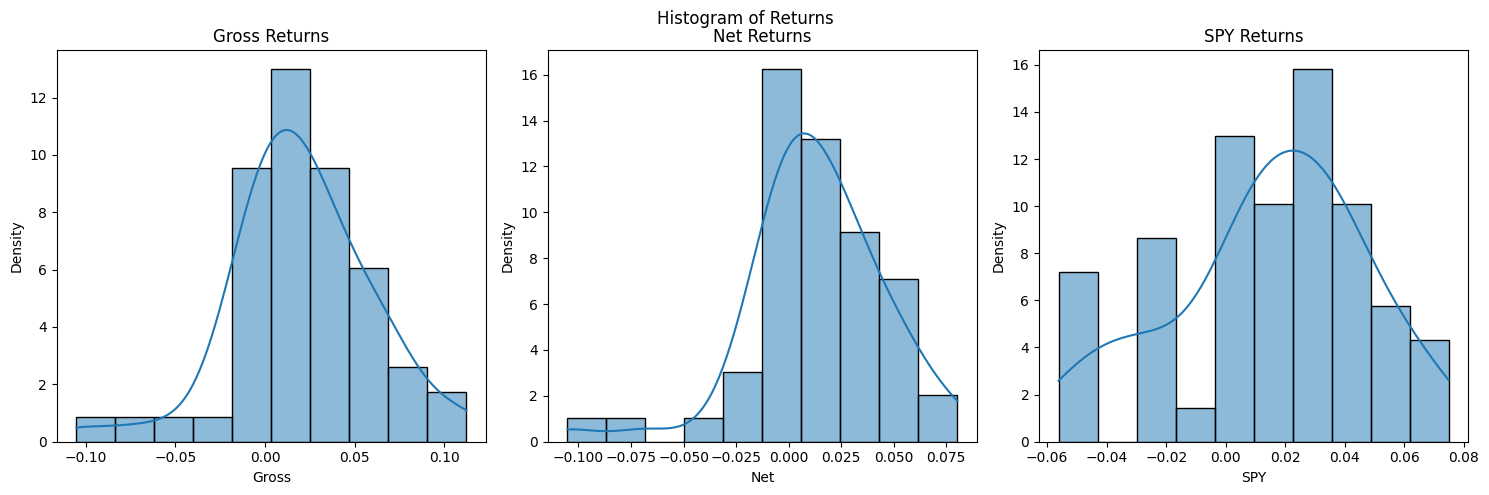

In [49]:
#individual histogram plot of returns of Gross, Net and SPY
titles = ['Gross Returns', 'Net Returns', 'SPY Returns']
columns = ['Gross', 'Net', 'SPY']

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    sns.histplot(returns_data[columns[i]], ax=ax[i], bins = 10, kde = True, stat = 'density')
    ax[i].set_title(titles[i])

fig.suptitle('Histogram of Returns')
fig.tight_layout()
fig.subplots_adjust(top=0.9)

plt.show()

In terms of gross, LTCM outperforms SPY on all metrics. However, net of fees, they seems to underperform the SPY whether it is in terms of mean, volatility or sharpe. This could mean that their costs are very high. 

LTCM has much thinner tailed distribution (i.e. mesokurtic), meaning that it seems like its returns are not heavily subjected to outlier events relative to SPY. It is more negatively skewed (net of fees) compared to the SPX, although that might not be a bad thing. We can see from the diagram above that Net Returns are generally skewed positively, although negative returns are much higher (though more infrequent) relative to SPX.

### 2.2 Using the series of net LTCM excess returns, denoted $\tilde{r}^{LTCM}_t$, estimate the following regression:

$$\tilde{r}^{LTCM}_t = \alpha + \beta^{m} \tilde{r}^{m}_t + \epsilon_t$$

(a) Report $\alpha$ and $\beta^{m}$. Report the $R^2$ stat.

(b) From this regression, does LTCM appear to be a "closet indexer"?

(c) From the regression, does LTCM appear to deliver excess returns beyond the risk premium we expect from market exposure?


In [87]:
#alpha and beta of net return against spx using regression_based_performance function
net_model, model = regression_based_performance(returns_data['SPY'], returns_data['Net'], rf = 0, input_freq = 'm', output_freq = 'a', constant = True)
net_model.loc[['alpha', 'beta', 'r_squared']]

,Value
alpha,0.131527
beta,0.137114
r_squared,0.018979


Given the low $\mathbb{R}^{2}$ value, it is probably not a "closet indexer". Also, LTCM does seem to deliver good excess return over the market given the annulised alpha of 13%. 

### 2.3 Let’s check for non-linear market exposure. Run the following regression on LTCM’s net excess returns:

$$\tilde{r}^{LTCM}_t = \alpha + \beta^{m}_{1} \tilde{r}^{m}_t + \beta^{m}_{2} (\tilde{r}^{m}_t)^{2} + \epsilon_t$$

(a) Report $\beta^{m}_{1}$, and $\beta^{m}_{2}$. Report the $R^2$ stat.

(b) Does the quadratic market factor do much to increase the overall LTCM variation explained by the market?

(c) From the regression evidence, does LTCM’s market exposure behave as if it is long market options or short market options?

(d) Should we describe LTCM as being positively or negatively exposed to market volatility?

In [70]:
net_model_quad = regression_based_performance(returns_data['SPY'], returns_data['Net'], rf = 0, input_freq = 'm', output_freq = 'a', constant = True, model_type = 'quadratic')
net_model_quad.loc[['alpha', 'beta', 'beta_squared', 'r_squared']]

,Value
alpha,0.155042
beta,0.166878
beta_squared,-1.926746
r_squared,0.024321


Clearly, adding the quadratic regression does not improve the fit of the regression. Given that the beta for market returns squared is negative, we can say that they are short volatility and hence strategy is short market options. i.e. returns are lower the larger market returns are. 

### 2.4 Let’s try to pinpoint the nature of LTCM’s nonlinear exposure. Does it come more from exposure to up-markets or down-markets? Run the following regression on LTCM’s net excess returns:

$$\tilde{r}^{LTCM}_t = \alpha + \beta \tilde{r}^{m}_t + \beta_{u} \max(\tilde{r}^{m}_t - k_{1}, 0) + \beta_{d} \max(k_{2} - \tilde{r}^{m}_t, 0) + \epsilon_t$$

where $k_1 = 0.03$ and $k_2=-0.03$

(a) Report $\beta$, $\beta_{u}$, and $\beta_{d}$. Report the $R^2$ stat.

(b) Is LTCM long or short the call-like factor? And the put-like factor?

(c) Which factor moves LTCM more, the call-like factor, or the put-like factor?

(d) In the previous problem, you commented on whether LTCM is positively or negatively exposed to market volatility. Using this current regression, does this volatility exposure come more from being long the market’s upside? Short the market’s downside? Something else?

In [73]:
net_model_nonlinear = regression_based_performance(returns_data['SPY'], returns_data['Net'], rf = 0, input_freq = 'm', output_freq = 'a', constant = True, model_type = 'piecewise', k1 = 0.03, k2 = -0.03)
net_model_nonlinear.loc[['alpha', 'beta', 'beta_u', 'beta_d', 'r_squared']]

,Value
alpha,0.101231
beta,0.466610
beta_u,-0.782140
beta_d,1.289575
r_squared,0.055486


LTCM is short the call-like factor and long the put-like factor, with the put-like factor being larger (i.e. LTCM is net short the market). Its short options exposure is a result of being short the call factor.  

## 3. The FX Carry Trade

Find an Excel data file, “fx carry data.xlsx”. The file has two sets of data:

- Risk-free rates across 5 currencies, as measured by annualized 3-month LIBOR rates.
- Spot FX rates, as direct quotes to the USD. (Note that all currencies are quoted as USD per the foreign currency.)

For use in the homework, note the following:
- For risk-free rate data, $r^{f,i}_{t,t+1}$, the rate is known and reported in the data at time $t$. Namely, any given date $t$ in the data file is reporting both $S^{i}_{t}$ and $r^{f,i}_{t,t+1}$
- The theory says to use log risk-free rates. You have the risk-free rate in levels: use the following equation to convert them: $r^{f,i}_{t,t+1}=\ln(1+r^{f,i}_{t,t+1})$
- The theory says to use log spot FX prices. You have the FX prices in levels, so directly take their logarithims: $s^{i}_{t}=\ln(S^{i}_{t})$


### 3.1 The Static Carry Trade
For each foreign currency, $i$, calculate the excess log return series,  $\tilde{r}^{t+1}$ . Report the following stats, (based on the excess log returns.) Annualize them.
(a) mean 

(b) volatility

(c) Sharpe ratio

What differences do you see across currencies?

In [78]:
logfxspot = np.log(fxspot)
logrf = np.log(1+rf).shift()
excesslogfxcarry = pd.DataFrame(index=logfxspot.index)
excesslogfxcarry['USUK'] = logfxspot.diff().USUK+logrf.GBP1M-logrf.USD1M
excesslogfxcarry['USEU'] = logfxspot.diff().USEU+logrf.EUR1M-logrf.USD1M
excesslogfxcarry['USSZ'] = logfxspot.diff().USSZ+logrf.CHF1M-logrf.USD1M
excesslogfxcarry['USJP'] = logfxspot.diff().USJP+logrf.JPY1M-logrf.USD1M
excesslogfxcarry = excesslogfxcarry.dropna()

In [80]:
fx_returns_calc = calc_stats(excesslogfxcarry, input_freq = 'm', output_freq = 'a', ci_level = 0.05)
fx_returns_calc[['Mean', 'Volatility', 'Sharpe Ratio']]

,Mean,Volatility,Sharpe Ratio
USUK,-0.003502,0.086303,-0.040574
USEU,-0.004351,0.094714,-0.045944
USSZ,0.004312,0.098757,0.043662
USJP,-0.017415,0.091492,-0.190342


We can see that the only currency with a positive sharpe is USSZ. In terms, volatility, all of them are fairly similar.

### 3.2 Implications for UIP:
(a) Do any of these stats contradict the (log version) of Uncovered Interest Parity (UIP)?

    Most of these are close for returns to zero so no. 

(b) A long position in which foreign currency offered the best Sharpe ratio over the sample?

    We can play on inverse USJP, i.e. long USD short JPY. 

(c) Are there any foreign currencies for which a long position earned a negative excess return (in USD) over the sample?

    All except SZ. 

### 3.3 Predicting FX:
For each foreign currency, test whether interest-rate differentials can predict growth in the foreign-exchange rate. Do this by estimating the following forecasting regression:

$$
s_{t+1}^{1}-s_{t}^{1}=\alpha^{i}+\beta^{i}(r_{t,t+1}^{f,\$}-r_{t,t+1}^{f,i})+\epsilon_{t+1}^{i}
$$

where $r^{f,i}$ denotes the risk-free rate of currency $i$ and $s^{i}$ denotes the FX rate for currency $i$. Again, note that both $r_{t,t+1}^{f,\$}$ and $s_{t}$ are determined at time $t$.

(a) Make a table with columns corresponding to a different currency regression.
Report the regression estimates $\alpha^{i}$ and $\beta^{i}$ in the first two rows. Report the $R^2$ stat in the third row.

(b) Suppose the foreign risk-free rate increases relative to the US rate.

&nbsp;&nbsp;&nbsp;&nbsp;i. For which foreign currencies would we predict a relative strengthening of the USD in the following period?  
&nbsp;&nbsp;&nbsp;&nbsp;ii. For which currencies would we predict relative weakening of the USD in the following period?  
&nbsp;&nbsp;&nbsp;&nbsp;iii. This FX predictability is strongest in the case of which foreign currency?



In [81]:
USD_CCY = pd.DataFrame(index=logfxspot.index)
USD_CCY['USUK'] = logrf.USD1M-logrf.GBP1M
USD_CCY['USEU'] = logrf.USD1M-logrf.EUR1M
USD_CCY['USSZ'] = logrf.USD1M-logrf.CHF1M
USD_CCY['USJP'] = logrf.USD1M-logrf.JPY1M
logfxret = logfxspot.diff()

USD_CCY.dropna(inplace = True)
logfxret.dropna(inplace = True)

reg_results = pd.DataFrame(columns = ['USUK', 'USEU', 'USSZ', 'USJP'], index = ['Alpha', 'Beta', 'R-Squared'])


for i in reg_results.columns:
    
    exog = sm.add_constant(USD_CCY[i])
    endog = logfxret[i]
    model = sm.OLS(endog, exog).fit()
    
    reg_results[i] = [model.params[0] * 12, model.params[1], model.rsquared]
    
    
display(reg_results)

,USUK,USEU,USSZ,USJP
Alpha,-0.005868,0.007033,0.043574,-0.005996
Beta,0.485836,-1.256358,-1.646596,0.371473
R-Squared,0.000382,0.002610,0.003948,0.000501


If the foreign rfr strengthen, we expect that the USD - rfr must go down. Hence:
- UK and JP should decrease relative to US (US strengthens relative)
- EU and SZ should increase relative to US (US weakens relative)

This effect seems to be the highest predictability for USSZ.

### 3.4 The Dynamic Carry Trade
Use this to write $E_t [ r_{t+1}^i ]$ as a function of the interest-rate differential as well as $\alpha$ and $\beta$ from this FX regression.

$$
E_t [ s_{t+1} - s_t ] = \alpha + \beta ( r_{t,t+1}^{f,\$} - r_{t,t+1}^{f,i} )
$$

Then use the definition of excess (log) returns on FX:

$$
\hat{r}_{t+1}^i = s_{t+1} - s_t - ( r_{t,t+1}^{f,\$} - r_{t,t+1}^{f,i} )
$$

Rearranging, this implies the following forecast for excess log returns:

$$
E_t [ \hat{r}_{t+1}^i ] = \alpha + (\beta - 1) ( r_{t,t+1}^{f,\$} - r_{t,t+1}^{f,i} )
$$

(a) Use your regression estimates from Problem 3 along with the formula above to calculate the fraction of months for which the estimated FX risk premium positive. That is, for each $i$, calculate how often in the time-series we have

$$
E_t [ \hat{r}_{t+1}^i ] > 0
$$

(b) Which currencies most consistently have a positive FX risk premium? And for which currencies does the FX risk premium most often go negative?

(c) Explain how we could use these conditional risk premia to improve the static carry trade returns calculated in Problem 1.


In [83]:
USUK_pred = (reg_results['USUK']['Alpha']/12) + (reg_results['USUK']['Beta'] - 1)*USD_CCY['USUK']
USEU_pred = (reg_results['USEU']['Alpha']/12) + (reg_results['USEU']['Beta'] - 1)*USD_CCY['USEU']
USSZ_pred = (reg_results['USSZ']['Alpha']/12) + (reg_results['USSZ']['Beta'] - 1)*USD_CCY['USSZ']
USJP_pred = (reg_results['USJP']['Alpha']/12) + (reg_results['USJP']['Beta'] - 1)*USD_CCY['USJP']
print('Expected USUK > 0 : {:,.2%} '.format(sum(USUK_pred > 0)/len(USUK_pred)))
print('Expected USEU > 0 : {:,.2%} '.format(sum(USEU_pred > 0)/len(USUK_pred)))
print('Expected USSZ > 0 : {:,.2%} '.format(sum(USSZ_pred > 0)/len(USUK_pred)))
print('Expected USJP > 0 : {:,.2%} '.format(sum(USJP_pred > 0)/len(USUK_pred)))

Expected USUK > 0 : 23.81% 
Expected USEU > 0 : 50.18% 
Expected USSZ > 0 : 63.00% 
Expected USJP > 0 : 0.00% 


Risk premium is most negative for JP. 